 🔍 甲基化窗口分析启动 | 目标区域: chrX:147911573-147912682

▶️ 正在读取样本: gScr ...
   ✅ 成功定位染色体: chrX
   📈 区域内位点数: 230
   📋 坐标范围: 147911574 到 147912682

▶️ 正在读取样本: gCGG ...
   ✅ 成功定位染色体: chrX
   📈 区域内位点数: 230
   📋 坐标范围: 147911574 到 147912682

▶️ 正在读取样本: gNHG3 ...
   ✅ 成功定位染色体: chrX
   📈 区域内位点数: 227
   📋 坐标范围: 147911574 到 147912682

⏳ 正在计算不同 Window Size 下的比值 (1bp 到 50bp)...

📊 分析完成! 图片已保存至: methylation_window_analysis.png
正在尝试显示图表...


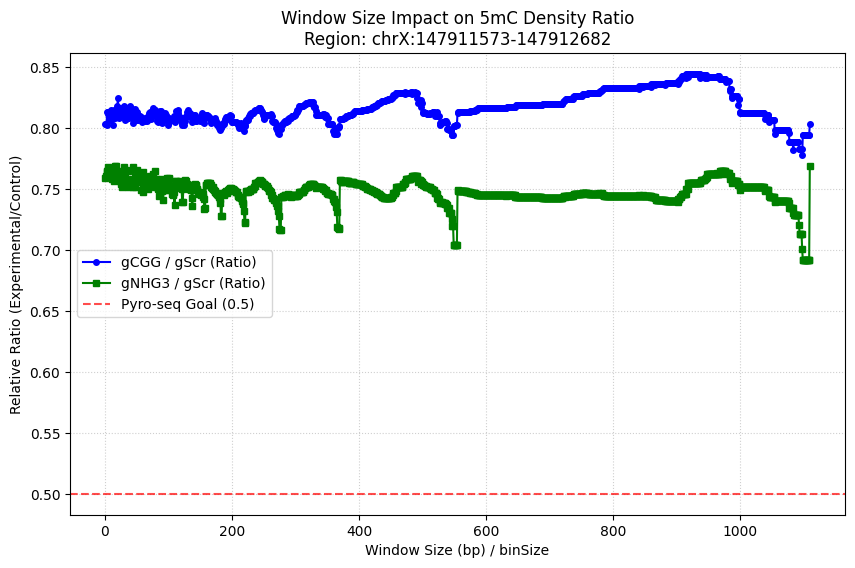

In [10]:
# 一代模型的原始计算
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ================= 1. 配置区 =================
FILE_PATHS = {
    'gScr': '675723-0427605772.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt',
    'gCGG': '675722-0427605773.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt',
    'gNHG3': '675720-0427605774.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt'
}

# 目标区域设置
REGION_CHR = 'chrX'         # 如果文件里是 X，请改为 'X'
REGION_START = 147911573
REGION_END = 147912682

# 列索引设置 (cxreport 标准格式)
# 0: Chr, 1: Pos, 2: Strand, 3: 5mC_Count, 4: 5hmC_Count, 5: Context, 6: Trinucleotide
POS_IDX = 1
M5C_IDX = 3

# ================= 2. 核心逻辑 =================

def run_analysis():
    print("="*50)
    print(f" 🔍 甲基化窗口分析启动 | 目标区域: {REGION_CHR}:{REGION_START}-{REGION_END}")
    print("="*50)
    
    all_data = {}
    
    for name, path in FILE_PATHS.items():
        if not os.path.exists(path):
            print(f"❌ 错误: 找不到文件 {path}")
            continue
            
        print(f"\n▶️ 正在读取样本: {name} ...")
        # 仅读取必要的列以节省内存
        df = pd.read_csv(path, sep='\t', header=None, usecols=[0, 1, 3])
        
        # 强制格式转换，防止匹配失效
        df[0] = df[0].astype(str).str.strip()
        df[1] = df[1].astype(int)
        
        # 自动计算库大小 (全基因组总 5mC Counts)
        lib_size = df[3].sum()
        
        # 【解决 chr1 误导问题】: 仅针对目标染色体进行筛选
        mask = (df[0] == REGION_CHR) & (df[1] >= REGION_START) & (df[1] <= REGION_END)
        region_df = df[mask].copy()
        
        if not region_df.empty:
            actual_chr = region_df.iloc[0, 0]
            print(f"   ✅ 成功定位染色体: {actual_chr}")
            print(f"   📈 区域内位点数: {len(region_df)}")
            print(f"   📋 坐标范围: {region_df[1].min()} 到 {region_df[1].max()}")
        else:
            print(f"   ⚠️ 警告: 在 {REGION_CHR} 该区间未找到位点！")
            # 自动诊断：打印文件里实际存在的染色体名，帮你排查是否是 'X' 还是 'chrX'
            unique_chrs = df[0].unique()[:5]
            print(f"   💡 调试信息: 文件前5个染色体名为 {unique_chrs}")
            continue
        
        # 计算 CPM (Counts Per Million)
        region_df['cpm'] = (region_df[3] / lib_size) * 1e6
        all_data[name] = region_df

    # 检查基准组是否存在
    if 'gScr' not in all_data or all_data['gScr'].empty:
        print("\n❌ 严重错误: 基准组 gScr 无有效数据，无法计算比值。")
        return

    # --- 3. 模拟不同 Window Size 的 Density 分析 ---
    print("\n⏳ 正在计算不同 Window Size 下的比值 (1bp 到 50bp)...")
    results = []
    
    # 模拟 multiBigwigSummary 的 unweighted mean 逻辑
    for w in range(1, 1110):
        step_means = {}
        for name in FILE_PATHS.keys():
            df = all_data.get(name)
            if df is None or df.empty:
                step_means[name] = 0
                continue
            
            # 划分连续的 Bin
            bins = np.arange(REGION_START, REGION_END + w, w)
            binned_vals = []
            
            for i in range(len(bins)-1):
                b_start, b_end = bins[i], bins[i+1]
                # 找出落在该 Bin 内的位点
                points_in_bin = df[(df[1] >= b_start) & (df[1] < b_end)]['cpm']
                
                if not points_in_bin.empty:
                    # Unweighted Mean: 每一个 Bin 的值是其内部位点的算术平均
                    binned_vals.append(points_in_bin.mean())
                else:
                    binned_vals.append(0) # 无信号区在 BigWig 中记为 0
            
            # 该 Window 下整个区域的密度均值
            step_means[name] = np.mean(binned_vals)
        
        # 计算实验组相对于 gScr 的减少比例
        scr_val = step_means['gScr']
        results.append({
            'window': w,
            'ratio_gCGG': step_means['gCGG'] / scr_val if scr_val > 0 else 0,
            'ratio_gNHG3': step_means['gNHG3'] / scr_val if scr_val > 0 else 0
        })

    # --- 4. 绘图与保存 ---
    res_df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    
    plt.plot(res_df['window'], res_df['ratio_gCGG'], 'b-o', label='gCGG / gScr (Ratio)', markersize=4)
    plt.plot(res_df['window'], res_df['ratio_gNHG3'], 'g-s', label='gNHG3 / gScr (Ratio)', markersize=4)
    
    # 标注 Pyro-seq 的 50% 预期线
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Pyro-seq Goal (0.5)')
    
    plt.title(f'Window Size Impact on 5mC Density Ratio\nRegion: {REGION_CHR}:{REGION_START}-{REGION_END}', fontsize=12)
    plt.xlabel('Window Size (bp) / binSize', fontsize=10)
    plt.ylabel('Relative Ratio (Experimental/Control)', fontsize=10)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    save_name = 'methylation_window_analysis.png'
    plt.savefig(save_name, dpi=300)
    print(f"\n📊 分析完成! 图片已保存至: {save_name}")
    print("正在尝试显示图表...")
    plt.show()

if __name__ == "__main__":
    run_analysis()

 🔍 甲基化稳定性分析 (CV + Ratio) | 区域: chrX:147911573-147912682
▶️ 正在预加载样本: gScr ...
   ✅ 抓取到 230 个 CG 位点
▶️ 正在预加载样本: gCGG ...
   ✅ 抓取到 230 个 CG 位点
▶️ 正在预加载样本: gNHG3 ...
   ✅ 抓取到 227 个 CG 位点

⏳ 正在计算不同 Window 下的均值与 CV 值...

📊 分析完成！结果图已保存为: methylation_cv_analysis.png


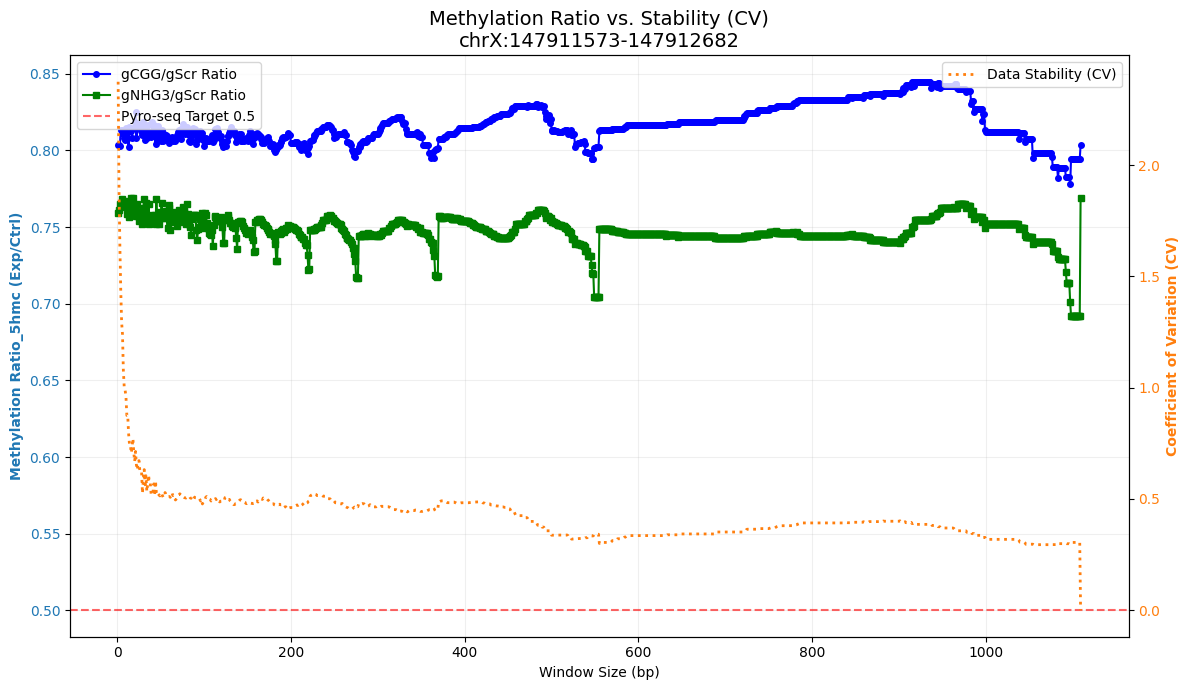

In [5]:
# 一代模型带有CV收敛情况
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. 配置 ---
FILE_PATHS = {
    'gScr': '675723-0427605772.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt',
    'gCGG': '675722-0427605773.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt',
    'gNHG3': '675720-0427605774.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt'
}

# 建议使用你完整区间来观察 CV 的收敛
REGION_CHR = 'chrX'
REGION_START = 147911573 
REGION_END = 147912682

def run_stability_analysis():
    print("="*60)
    print(f" 🔍 甲基化稳定性分析 (CV + Ratio) | 区域: {REGION_CHR}:{REGION_START}-{REGION_END}")
    print("="*60)
    
    all_data = {}
    
    # --- 第一步：读取与预处理 ---
    for name, path in FILE_PATHS.items():
        if not os.path.exists(path):
            print(f"❌ 找不到文件: {path}")
            continue
            
        print(f"▶️ 正在预加载样本: {name} ...")
        df = pd.read_csv(path, sep='\t', header=None, usecols=[0, 1, 3, 5])
        
        lib_size = df[3].sum()
        df[0] = df[0].astype(str).str.strip()
        df[5] = df[5].astype(str).str.strip()
        
        mask = (df[0] == REGION_CHR) & \
               (df[1] >= REGION_START) & \
               (df[1] <= REGION_END) & \
               (df[5] == 'CG')
        
        region_df = df[mask].copy()
        region_df['cpm'] = (region_df[3] / lib_size) * 1e6
        all_data[name] = region_df
        print(f"   ✅ 抓取到 {len(region_df)} 个 CG 位点")

    if 'gScr' not in all_data: return

    # --- 第二步：多尺度窗口计算 ---
    results = []
    # 测试 1bp 到 500bp 的窗口，每隔 10bp 取样
    window_range = range(1, 1110, 1) 
    
    print("\n⏳ 正在计算不同 Window 下的均值与 CV 值...")
    for w in window_range:
        current_step = {'window': w}
        
        for name, df in all_data.items():
            bins = np.arange(REGION_START, REGION_END + w, w)
            binned_vals = []
            
            for i in range(len(bins)-1):
                pts = df[(df[1] >= bins[i]) & (df[1] < bins[i+1])]['cpm']
                binned_vals.append(pts.mean() if not pts.empty else 0)
            
            # 核心统计量：均值与 CV
            mu = np.mean(binned_vals)
            sigma = np.std(binned_vals)
            
            current_step[f'{name}_mean'] = mu
            current_step[f'{name}_cv'] = (sigma / mu) if mu > 0 else 0
            
        # 计算相对于对照组的比值
        current_step['ratio_gCGG'] = current_step['gCGG_mean'] / current_step['gScr_mean'] if current_step['gScr_mean'] > 0 else 0
        current_step['ratio_gNHG3'] = current_step['gNHG3_mean'] / current_step['gScr_mean'] if current_step['gScr_mean'] > 0 else 0
        results.append(current_step)

    res_df = pd.DataFrame(results).set_index('window')

    # --- 第三步：双 Y 轴绘图 ---
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # 左轴：Ratio
    color_ratio = 'tab:blue'
    ax1.set_xlabel('Window Size (bp)')
    ax1.set_ylabel('Methylation Ratio_5hmc (Exp/Ctrl)', color=color_ratio, fontweight='bold')
    ax1.plot(res_df.index, res_df['ratio_gCGG'], 'b-o', label='gCGG/gScr Ratio', markersize=4)
    ax1.plot(res_df.index, res_df['ratio_gNHG3'], 'g-s', label='gNHG3/gScr Ratio', markersize=4)
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.6, label='Pyro-seq Target 0.5')
    ax1.tick_params(axis='y', labelcolor=color_ratio)

    # 右轴：CV (稳定性)
    ax2 = ax1.twinx()
    color_cv = 'tab:orange'
    ax2.set_ylabel('Coefficient of Variation (CV)', color=color_cv, fontweight='bold')
    # 我们以 gScr 的 CV 作为数据稳定性的代表
    ax2.plot(res_df.index, res_df['gScr_cv'], color=color_cv, linestyle=':', linewidth=2, label='Data Stability (CV)')
    ax2.tick_params(axis='y', labelcolor=color_cv)

    plt.title(f'Methylation Ratio vs. Stability (CV)\n{REGION_CHR}:{REGION_START}-{REGION_END}', fontsize=14)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.savefig('methylation_cv_analysis.png')
    print("\n📊 分析完成！结果图已保存为: methylation_cv_analysis.png")
    plt.show()

if __name__ == "__main__":
    run_stability_analysis()

In [ ]:
# 一代模型添加了滑动窗口+滑动偏移+CV曲线
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. 配置 ---
FILE_PATHS = {
    'gScr': '675723-0427605772.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt',
    'gCGG': '675722-0427605773.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt',
    'gNHG3': '675720-0427605774.targeted.GRCh38Decoy.markdup.CG.num_mc_cxreport.txt'
}

REGION_CHR = 'chrX'
REGION_START = 147910019
REGION_END = 147914019

OFFSETS = [0, 5, 10]  # 偏移量测试
SLIDE_STEP = 5        # 滑动步长

def run_comprehensive_analysis():
    print("="*60)
    print(f" 🔍 全指标分析：gCGG & gNHG3 收敛性对比 | 区域: {REGION_CHR}:{REGION_START}-{REGION_END}")
    print("="*60)
    
    all_data = {}
    for name, path in FILE_PATHS.items():
        if not os.path.exists(path): 
            print(f"⚠️ 找不到文件: {name}"); continue
        df = pd.read_csv(path, sep='\t', header=None, usecols=[0, 1, 3, 5])
        lib_size = df[3].sum()
        mask = (df[0].astype(str).str.strip() == REGION_CHR) & \
               (df[1] >= REGION_START) & (df[1] <= REGION_END) & \
               (df[5].astype(str).str.strip() == 'CG')
        rdf = df[mask].copy()
        rdf['cpm'] = (rdf[3] / lib_size) * 1e6
        all_data[name] = rdf

    results = []
    window_range = range(1, 1000, 1) 
    
    for w in window_range:
        current_step = {'window': w}
        
        # --- 1. 固定切分 + 多重偏移 (用于计算阴影/稳定性) ---
        tmp_ratios_cgg = []
        tmp_ratios_nhg3 = []
        
        for os_val in OFFSETS:
            bins = np.arange(REGION_START + os_val, REGION_END + w, w)
            means = {}
            for name, df in all_data.items():
                b_vals = [df[(df[1] >= bins[i]) & (df[1] < bins[i+1])]['cpm'].mean() for i in range(len(bins)-1)]
                b_vals = [v for v in b_vals if not np.isnan(v)]
                means[name] = np.mean(b_vals) if b_vals else 0
            
            if means.get('gScr', 0) > 0:
                tmp_ratios_cgg.append(means['gCGG'] / means['gScr'])
                tmp_ratios_nhg3.append(means['gNHG3'] / means['gScr'])
        
        # 存储 gCGG 的统计量
        current_step['cgg_fixed_mean'] = np.mean(tmp_ratios_cgg) if tmp_ratios_cgg else 0
        current_step['cgg_fixed_std'] = np.std(tmp_ratios_cgg) if tmp_ratios_cgg else 0
        # 存储 gNHG3 的统计量
        current_step['nhg3_fixed_mean'] = np.mean(tmp_ratios_nhg3) if tmp_ratios_nhg3 else 0
        current_step['nhg3_fixed_std'] = np.std(tmp_ratios_nhg3) if tmp_ratios_nhg3 else 0

        # --- 2. 滑动窗口曲线 (更连续的趋势) ---
        slide_means = {}
        for name, df in all_data.items():
            starts = np.arange(REGION_START, REGION_END - w + 1, SLIDE_STEP)
            if len(starts) == 0: starts = [REGION_START]
            b_vals = []
            for s in starts:
                pts = df[(df[1] >= s) & (df[1] < s + w)]['cpm']
                if not pts.empty: b_vals.append(pts.mean())
            slide_means[name] = np.mean(b_vals) if b_vals else 0
            
        if slide_means.get('gScr', 0) > 0:
            current_step['cgg_sliding'] = slide_means['gCGG'] / slide_means['gScr']
            current_step['nhg3_sliding'] = slide_means['gNHG3'] / slide_means['gScr']
        
        # --- 3. 记录 gScr 的 CV ---
        scr_df = all_data['gScr']
        all_bins_vals = [scr_df[(scr_df[1] >= REGION_START + i) & (scr_df[1] < REGION_START + i + w)]['cpm'].mean() for i in range(0, (REGION_END-REGION_START), SLIDE_STEP)]
        all_bins_vals = [v for v in all_bins_vals if not np.isnan(v)]
        current_step['scr_cv'] = np.std(all_bins_vals)/np.mean(all_bins_vals) if np.mean(all_bins_vals) > 0 else 0

        results.append(current_step)

    res_df = pd.DataFrame(results).set_index('window')

    # --- 绘图 ---
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # gCGG 数据线 (蓝色)
    ax1.plot(res_df.index, res_df['cgg_sliding'], '-D', color='blue', linewidth=2, label=f'gCGG Sliding (Step={SLIDE_STEP}bp)')
    ax1.fill_between(res_df.index, res_df['cgg_fixed_mean'] - res_df['cgg_fixed_std'], 
                     res_df['cgg_fixed_mean'] + res_df['cgg_fixed_std'], color='blue', alpha=0.1, label='gCGG Offset Sensitivity')
    
    # gNHG3 数据线 (绿色)
    ax1.plot(res_df.index, res_df['nhg3_sliding'], '-s', color='green', linewidth=2, label=f'gNHG3 Sliding (Step={SLIDE_STEP}bp)')
    ax1.fill_between(res_df.index, res_df['nhg3_fixed_mean'] - res_df['nhg3_fixed_std'], 
                     res_df['nhg3_fixed_mean'] + res_df['nhg3_fixed_std'], color='green', alpha=0.1, label='gNHG3 Offset Sensitivity')
    
    ax1.set_xlabel('Window Size (bp)', fontweight='bold')
    ax1.set_ylabel('Methylation Ratio (Exp/Ctrl)', fontweight='bold')
    ax1.axhline(y=0.5, color='red', linestyle=':', label='Target 0.5 (Reference)')
    ax1.set_ylim(0, 1.5) # 根据实际数据范围调整

    # 右轴：CV 收敛情况
    ax2 = ax1.twinx()
    ax2.plot(res_df.index, res_df['scr_cv'], 'r:', linewidth=2, label='Spatial CV (Stability)')
    ax2.set_ylabel('CV (Coefficient of Variation)', color='red', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title(f'Multi-group 5mc Convergence Analysis: gCGG & gNHG3\n{REGION_CHR}:{REGION_START}-{REGION_END}', fontsize=14)
    ax1.legend(loc='upper left', fontsize='small', ncol=2)
    ax2.legend(loc='upper right', fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('multi_group_convergence.png')
    plt.show()

run_comprehensive_analysis()

 🔍 全指标分析：gCGG & gNHG3 收敛性对比 | 区域: chrX:147910019-147914019


 🔍 执行收敛性分析：gCGG & gNHG3 | 区域: chrX:147911803-147911850


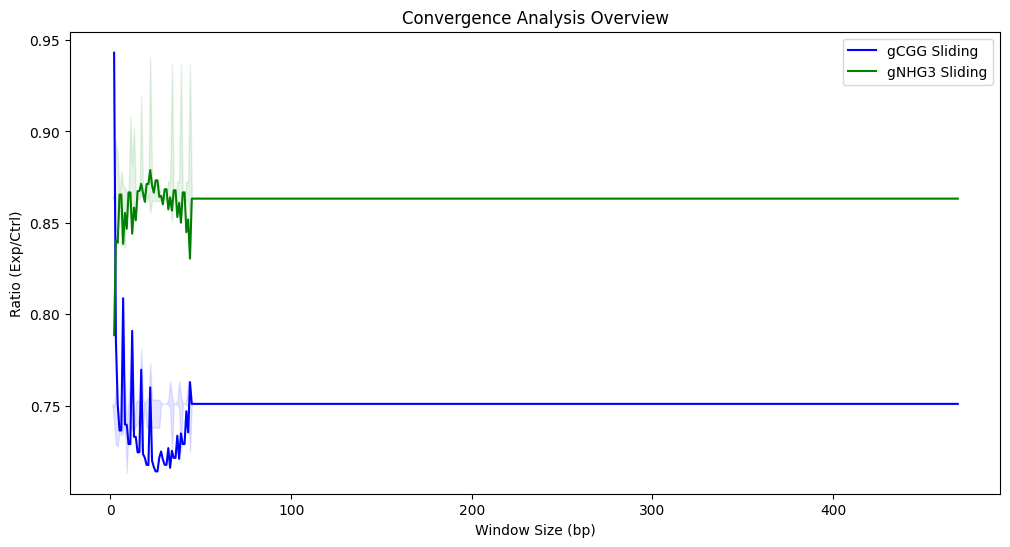


📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
 选定分析窗口: 30 bp
----------------------------------------
 gCGG Ratio  : 0.7175 (±0.0000)
 gNHG3 Ratio : 0.8684 (±0.0000)
 Spatial CV  : 0.0365
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊



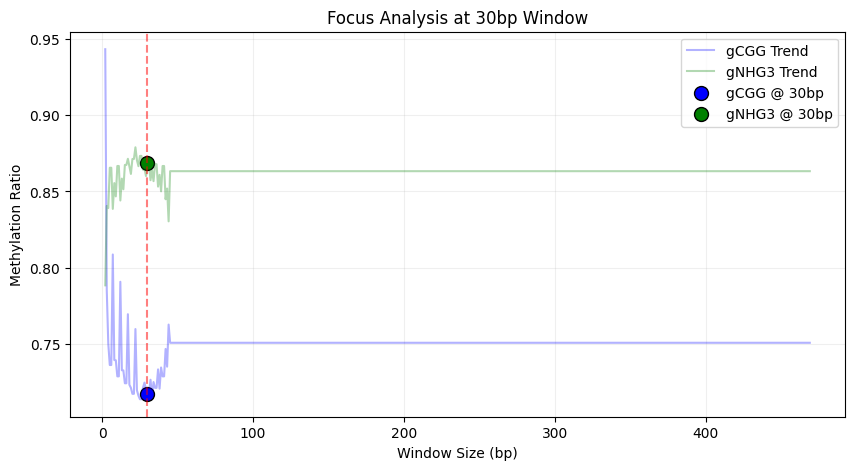

In [5]:
# 一代模型：下游的选定window size的分析

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. 配置参数 ---
FILE_PATHS = {
    'gScr': '675723-0427605772.targeted.GRCh38Decoy.markdup.CG.num_modc_cxreport.txt',
    'gCGG': '675722-0427605773.targeted.GRCh38Decoy.markdup.CG.num_modc_cxreport.txt',
    'gNHG3': '675720-0427605774.targeted.GRCh38Decoy.markdup.CG.num_modc_cxreport.txt'
}

# 你的 FMR1 核心研究区域 (47bp)
REGION_CHR = 'chrX'
REGION_START = 147911803  
REGION_END = 147911850

OFFSETS = [0, 5, 10]  # 用于测试边界稳健性的偏移量
SLIDE_STEP = 5        # 滑动窗口的步长

def run_comprehensive_analysis():
    print("="*60)
    print(f" 🔍 执行收敛性分析：gCGG & gNHG3 | 区域: {REGION_CHR}:{REGION_START}-{REGION_END}")
    print("="*60)
    
    all_data = {}
    for name, path in FILE_PATHS.items():
        if not os.path.exists(path): 
            print(f"⚠️ 找不到文件: {path}"); continue
        
        # 加载数据 (假设格式为: chr, pos, strand, count_C, count_T, context)
        df = pd.read_csv(path, sep='\t', header=None, usecols=[0, 1, 3, 5])
        lib_size = df[3].sum() # 用于 CPM 归一化
        
        # 严格过滤目标区域内的 CG 位点
        mask = (df[0].astype(str).str.strip() == REGION_CHR) & \
               (df[1] >= REGION_START) & (df[1] <= REGION_END) & \
               (df[5].astype(str).str.strip() == 'CG')
        
        rdf = df[mask].copy()
        rdf['cpm'] = (rdf[3] / lib_size) * 1e6
        all_data[name] = rdf

    if not all_data:
        print("❌ 错误：未加载到任何有效数据。"); return None

    results = []
    # 扫描窗口大小 (从 1bp 到约 470bp，根据你的区域长度调整)
    window_range = range(1, 470, 1) 
    
    for w in window_range:
        current_step = {'window': w}
        
        # --- A. 固定分箱 + 多重偏移 (用于计算阴影/稳定性) ---
        tmp_ratios_cgg = []
        tmp_ratios_nhg3 = []
        
        for os_val in OFFSETS:
            bins = np.arange(REGION_START + os_val, REGION_END + w, w)
            means = {}
            for name, df in all_data.items():
                # 计算每个分箱的 CPM 均值
                b_vals = [df[(df[1] >= bins[i]) & (df[1] < bins[i+1])]['cpm'].mean() for i in range(len(bins)-1)]
                b_vals = [v for v in b_vals if not np.isnan(v)]
                means[name] = np.mean(b_vals) if b_vals else 0
            
            # 以 gScr 为基准计算比值
            if means.get('gScr', 0) > 0:
                tmp_ratios_cgg.append(means['gCGG'] / means['gScr'])
                tmp_ratios_nhg3.append(means['gNHG3'] / means['gScr'])
        
        current_step['cgg_fixed_mean'] = np.mean(tmp_ratios_cgg) if tmp_ratios_cgg else 0
        current_step['cgg_fixed_std'] = np.std(tmp_ratios_cgg) if tmp_ratios_cgg else 0
        current_step['nhg3_fixed_mean'] = np.mean(tmp_ratios_nhg3) if tmp_ratios_nhg3 else 0
        current_step['nhg3_fixed_std'] = np.std(tmp_ratios_nhg3) if tmp_ratios_nhg3 else 0

        # --- B. 滑动窗口逻辑 (消除边界截断效应) ---
        slide_means = {}
        for name, df in all_data.items():
            starts = np.arange(REGION_START, REGION_END - w + 1, SLIDE_STEP)
            if len(starts) == 0: starts = [REGION_START]
            b_vals = []
            for s in starts:
                pts = df[(df[1] >= s) & (df[1] < s + w)]['cpm']
                if not pts.empty: b_vals.append(pts.mean())
            slide_means[name] = np.mean(b_vals) if b_vals else 0
            
        if slide_means.get('gScr', 0) > 0:
            current_step['cgg_sliding'] = slide_means['gCGG'] / slide_means['gScr']
            current_step['nhg3_sliding'] = slide_means['gNHG3'] / slide_means['gScr']
        
        # --- C. 计算稳定性指标 (Spatial CV) ---
        scr_df = all_data['gScr']
        # 使用滑动窗口计算 gScr 内部的空间变异
        scr_spatial_vals = [scr_df[(scr_df[1] >= REGION_START + i) & (scr_df[1] < REGION_START + i + w)]['cpm'].mean() 
                            for i in range(0, (REGION_END-REGION_START), SLIDE_STEP)]
        scr_spatial_vals = [v for v in scr_spatial_vals if not np.isnan(v)]
        
        if len(scr_spatial_vals) > 1 and np.mean(scr_spatial_vals) > 0:
            current_step['scr_cv'] = np.std(scr_spatial_vals) / np.mean(scr_spatial_vals)
        else:
            current_step['scr_cv'] = 0

        results.append(current_step)

    res_df = pd.DataFrame(results).set_index('window')

    # --- 绘制概览图 ---
    plt.figure(figsize=(12, 6))
    plt.plot(res_df.index, res_df['cgg_sliding'], color='blue', label='gCGG Sliding')
    plt.fill_between(res_df.index, res_df['cgg_fixed_mean'] - res_df['cgg_fixed_std'], 
                     res_df['cgg_fixed_mean'] + res_df['cgg_fixed_std'], color='blue', alpha=0.1)
    
    plt.plot(res_df.index, res_df['nhg3_sliding'], color='green', label='gNHG3 Sliding')
    plt.fill_between(res_df.index, res_df['nhg3_fixed_mean'] - res_df['nhg3_fixed_std'], 
                     res_df['nhg3_fixed_mean'] + res_df['nhg3_fixed_std'], color='green', alpha=0.1)
    
    plt.title("Convergence Analysis Overview")
    plt.xlabel("Window Size (bp)")
    plt.ylabel("Ratio (Exp/Ctrl)")
    plt.legend()
    plt.show()

    return res_df # ⭐ 重要：返回结果 DataFrame

def report_fixed_window(res_df, target_w):
    """ 指定 Window Size 提取具体数值并绘图标注 """
    if res_df is None: return
    
    # 自动寻找最接近的窗口大小
    if target_w not in res_df.index:
        target_w = res_df.index[np.abs(res_df.index - target_w).argmin()]
    
    stats = res_df.loc[target_w]
    
    print("\n" + "📊" * 20)
    print(f" 选定分析窗口: {target_w} bp")
    print("-" * 40)
    print(f" gCGG Ratio  : {stats['cgg_sliding']:.4f} (±{stats['cgg_fixed_std']:.4f})")
    print(f" gNHG3 Ratio : {stats['nhg3_sliding']:.4f} (±{stats['nhg3_fixed_std']:.4f})")
    print(f" Spatial CV  : {stats['scr_cv']:.4f}")
    print("📊" * 20 + "\n")

    # 绘制局部高亮图
    plt.figure(figsize=(10, 5))
    plt.plot(res_df.index, res_df['cgg_sliding'], label='gCGG Trend', color='blue', alpha=0.3)
    plt.plot(res_df.index, res_df['nhg3_sliding'], label='gNHG3 Trend', color='green', alpha=0.3)
    
    # 标注点
    plt.scatter([target_w], [stats['cgg_sliding']], color='blue', s=100, edgecolors='black', label=f'gCGG @ {target_w}bp')
    plt.scatter([target_w], [stats['nhg3_sliding']], color='green', s=100, edgecolors='black', label=f'gNHG3 @ {target_w}bp')
    
    plt.axvline(x=target_w, color='red', linestyle='--', alpha=0.5)
    plt.ylabel("Methylation Ratio")
    plt.xlabel("Window Size (bp)")
    plt.title(f"Focus Analysis at {target_w}bp Window")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# --- 运行流程 ---
if __name__ == "__main__":
    # 1. 运行完整分析
    final_results = run_comprehensive_analysis()
    
    # 2. 如果分析成功，锁定 30bp (或你观察到的收敛点) 查看结果
    if final_results is not None:
        report_fixed_window(final_results, target_w=30)

In [ ]:
# 一代模型适合用于决定非常小的片段的最佳window size，随着测试区域的增大，CV会有偏向更大window size的趋势

In [ ]:
# 二代模型：可以确定稍微大一些片段的window size:1000-3000bp,过于大的测试片段也会出现综合评分偏向大的window size的趋势（可以给综合评分中的三个参数改）
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. 配置 ---
FILE_PATHS = {
    'gScr': '675723-0427605772.targeted.GRCh38Decoy.markdup.CG.num_modc_cxreport.txt',
    'gCGG': '675722-0427605773.targeted.GRCh38Decoy.markdup.CG.num_modc_cxreport.txt',
    'gNHG3': '675720-0427605774.targeted.GRCh38Decoy.markdup.CG.num_modc_cxreport.txt'
}

REGION_CHR = 'chrX'
REGION_START = 147910979
REGION_END = 147913111
OFFSETS = [0, 5, 10]
SLIDE_STEP = 5

def run_ultimate_analysis():
    print("🚀 正在通过分块加载优化内存...")
    all_signals = {}
    
    # 预设数据类型以加速加载
    dtypes = {0: str, 1: int, 3: int, 5: str}
    
    for name, path in FILE_PATHS.items():
        if not os.path.exists(path):
            print(f"⚠️ 找不到文件: {path}"); continue
            
        # 仅读取必要列并快速筛选目标区间，避免全量载入
        chunks = pd.read_csv(path, sep='\t', header=None, usecols=[0, 1, 3, 5], 
                             dtype=dtypes, chunksize=500000)
        
        relevant_data = []
        total_lib_size = 0
        
        for chunk in chunks:
            total_lib_size += chunk[3].sum()
            # 这里的筛选非常关键，只保留 chrX 目标区域
            mask = (chunk[0].str.strip() == REGION_CHR) & \
                   (chunk[1] >= REGION_START) & (chunk[1] <= REGION_END)
            relevant_data.append(chunk[mask])
        
        rdf = pd.concat(relevant_data)
        
        # 映射到 2001bp 的 Numpy 阵列
        sig = np.zeros(REGION_END - REGION_START + 1)
        pos = rdf[1].values - REGION_START
        cpm = (rdf[3].values / total_lib_size) * 1e6
        sig[pos] = cpm
        all_signals[name] = sig

    window_range = [1, 10, 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]
    results = []

    print(f"📊 正在计算 {len(window_range)} 个窗口的四维度指标...")
    for w in window_range:
        res = {'window': w}
        
        # 指标 1: 滑动窗口均值与 CV (稳定性)
        for name, sig in all_signals.items():
            starts = np.arange(0, len(sig) - w + 1, SLIDE_STEP)
            wins = [sig[i:i+w].mean() for i in starts]
            res[f'{name}_slide'] = np.mean(wins) if wins else 0
            if name == 'gScr':
                res['scr_cv'] = np.std(wins) / np.mean(wins) if np.mean(wins) > 0 else 0

        # 指标 2 & 3: 偏移敏感度与阴影面积 (稳健性)
        for raw_name, clean_name in [('gCGG', 'cgg'), ('gNHG3', 'nhg3')]:
            off_ratios = []
            for d in OFFSETS:
                max_pos = len(all_signals['gScr']) - w
                bins = np.arange(d, max_pos, w)
                if len(bins) < 1: continue
                m_scr = np.mean([all_signals['gScr'][int(b):int(b+w)].mean() for b in bins])
                m_exp = np.mean([all_signals[raw_name][int(b):int(b+w)].mean() for b in bins])
                if m_scr > 0: off_ratios.append(m_exp / m_scr)
            
            res[f'{clean_name}_offset_mean'] = np.mean(off_ratios) if off_ratios else 0
            res[f'{clean_name}_offset_std'] = np.std(off_ratios) if off_ratios else 0 # 阴影厚度

        results.append(res)

    res_df = pd.DataFrame(results).set_index('window')
    
    # --- 综合评分逻辑 ---
    def norm(s): return (s - s.min()) / (s.max() - s.min() + 1e-9)

    for grp in ['cgg', 'nhg3']:
        base = res_df.loc[1, f'g{grp.upper()}_slide'] / res_df.loc[1, 'gScr_slide']
        res_df[f'{grp}_ratio'] = res_df[f'g{grp.upper()}_slide'] / res_df['gScr_slide']
        res_df[f'{grp}_bias_pct'] = np.abs(res_df[f'{grp}_ratio'] - base) / (base + 1e-9) * 100

    # 效用计算：追求高稳定 (1-CV)，惩罚高偏差 (Bias) 与高不确定性 (Offset Std)
    res_df['score_stability'] = 1 - norm(res_df['scr_cv'])
    res_df['score_penalty'] = norm(res_df['cgg_bias_pct'] + res_df['nhg3_bias_pct']) + \
                              norm(res_df['cgg_offset_std'] + res_df['nhg3_offset_std'])
    
    res_df['combined_score'] = res_df['score_stability'] / (res_df['score_penalty'] + 0.1)
    
    # 自动获取最佳窗口
    best_w = res_df['combined_score'].idxmax()

    # --- 4. 绘图 ---
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1.5, 1]})
    colors = {'cgg': 'royalblue', 'nhg3': 'seagreen'}
    
    # 子图 1: Ratio & CV & Shaded Area
    for grp in ['cgg', 'nhg3']:
        ax1.plot(res_df.index, res_df[f'{grp}_ratio'], '-o', color=colors[grp], label=f'g{grp.upper()} Ratio')
        ax1.fill_between(res_df.index, 
                         res_df[f'{grp}_offset_mean'] - res_df[f'{grp}_offset_std'],
                         res_df[f'{grp}_offset_mean'] + res_df[f'{grp}_offset_std'], 
                         color=colors[grp], alpha=0.15, label=f'g{grp.upper()} Shaded Area')
    
    ax2 = ax1.twinx()
    ax2.plot(res_df.index, res_df['scr_cv'], 'r:', linewidth=2.5, label='Spatial CV (Stability)')
    ax2.set_ylabel('CV', color='red', fontweight='bold')
    ax1.set_title(f'FMR1 Multi-Metric Trade-off Analysis\nRecommended Window: {best_w} bp', fontsize=15)

    # 子图 2: Combined Score & Bias
    ax3.plot(res_df.index, res_df['combined_score'], '-o', color='darkviolet', linewidth=2.5, label='Combined Utility Score')
    ax3.axvline(x=best_w, color='orange', linestyle='--', linewidth=2, label=f'Best Trade-off: {best_w}bp')
    
    ax4 = ax3.twinx()
    ax4.plot(res_df.index, res_df['cgg_bias_pct'], '--', color='royalblue', alpha=0.4, label='gCGG Bias (%)')
    ax4.plot(res_df.index, res_df['nhg3_bias_pct'], '--', color='seagreen', alpha=0.4, label='gNHG3 Bias (%)')
    ax4.set_ylabel('Relative Bias (%) from 1bp', color='gray')
    
    ax3.set_xlabel('Window Size (bp)', fontweight='bold')
    ax3.set_ylabel('Utility Score', color='darkviolet', fontweight='bold')
    ax1.legend(loc='upper left', ncol=2, fontsize='small')
    ax3.legend(loc='upper left', fontsize='small')
    
    plt.tight_layout()
    plt.show()
    return best_w

if __name__ == "__main__":
    best_window = run_ultimate_analysis()
    print(f"✅ 分析完成！建议在全基因组分析中使用 Window Size = {best_window} bp")